In [1126]:
import camelot as c
from camelot import utils
import os
import pandas as pd
import matplotlib.pyplot as plt
import pyscreenshot as ss
import pytesseract as tes
import cv2
import numpy as np
import regex as re
import pandas as pd

files = os.listdir(r"C:\Users\there\Documents\Code\Numismatics\OCR\pdfs\simple")
pre = r"C:\Users\there\Documents\Code\Numismatics\OCR\pdfs\simple\\"

tes.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\\tesseract.exe"

In [1127]:
# for file in files:
#     pdf = pre + file
#     tables = c.read_pdf(pdf, "all")
#     for table in tables:
#         if table.parsing_report["accuracy"] > 0.90:
#             dir = f"./data/{file}"
#             if not os.path.exists(dir):
#                 os.mkdir(dir)
#             table.to_csv(dir + f"/{table.parsing_report['order']}.csv")

# Single-File

In [1128]:
# pdf = "Farhi_Y_2018_Coins_from_the_2008_2009_Ex"
# testPDF = pre + pdf + ".pdf" # 100,600,500,100 ||| 476,200,788,631 ||| tlx tly brx bry ||| (0,0) in BL corner
# tables = c.read_pdf(testPDF, "7", flavor="lattice", line_scale=40, line_tol=8, table_areas=["100,600,500,100"]) # line tolerance issues, must be variable. if too big, wont run

### Remove Duplicate Headers

In [1129]:
# overall_df = tables[0].df
# for table in tables[1:]:
#     cur_df = table.df

#     if cur_df[0][0] == overall_df[0][0]: # if non-initial table includes header again...
#         cur_df = cur_df.drop(0) # ...remove the header

#     overall_df = overall_df.merge(cur_df, how="outer")

In [1130]:
# cur_group = ""
# new_col = []
# group_indices = []

# for index, row in overall_df.iterrows():
#     if sum(value != "" for value in row) == 1: # if only one cell filled --- indicates this is a grouping label/separator
#         cur_group = next(value for value in row if value != "")
#         group_indices.append(index)
#     else:
#         new_col.append(cur_group)

# for index in group_indices:
#     overall_df = overall_df.drop(index)

# overall_df = overall_df.assign(group=new_col) # append new groups column

In [1131]:
# overall_df.to_csv("CUR.csv", index=False, header=False, encoding="utf-8") # need to add label for group depending on user input

In [1132]:
# print(table.parsing_report)
# pdf = "Farhi_Y_2018_Coins_from_the_2008_2009_Ex"
# testPDF = pre + pdf + ".pdf" # 100,600,500,100 ||| 476,200,788,631 ||| LX HiY RX LowY ||| (0,0) in BL corner ||| swap 2-4
# tables = c.read_pdf(testPDF, "7", flavor="lattice", line_scale=40, line_tol=8, table_areas=["0,755,577,100"]) # line tolerance issues, must be variable. if too big, wont run
# table = tables[0]
# c.plot(table, kind="contour") # line joint, text grid contour, textedge (Lat, Both, Stream)

# Bounding box tool

In [1133]:
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
import pymupdf as mu
from screeninfo import get_monitors
import ctypes

In [1134]:
values = [
    "ID",
    "Name",
    "Latitude",
    "Longitude",
    "Start_Year",
    "End_Year",
    "Num_Coins_Found",
    "Reference",
    "Comment",
    "External_Link"
    ]

mapping = {}
coins = []
grouping = ""
labels = {}
precise_date = False

In [1135]:
def is_separator(row):
    index = row[0]
    if (index is None or len(index) == 0 or len(index) >= 5 or not any(char.isdigit() for char in index) 
    or sum(1 for col in row if (col == "" or col == " " or col == None)) >= len(row) / 2):
        return True
    return False

In [1136]:
def is_header(row):
    return row[0].replace("\n", " ").replace("   ", " ").replace("  ", " ") == labels[0]

In [1137]:
def get_separator(row):
    return row.iloc[0]

In [1138]:
def append_data(coins, tables, grouping):
    count = 0
    for table in tables:
        table = table.df
        for i, row in table.iterrows():
            
            if is_separator(row):
                if is_header(row):
                    # print("WAS HEADER")
                    continue
                grouping = get_separator(row)
                continue
            
            coin = {}
            count += 1
            
            print(f"Label: {labels}")
            print(f"Mapping: {mapping}")

            for key, label in labels.items():
                try:
                    coin[mapping[label]] = row[key]
                except:
                    continue
            if mapping["grouping_label"] != "":
                coin[mapping["grouping_label"]] = grouping
            coins.append(coin)
    return count

In [1139]:
def upload_file(capture_button, tool):
    file_path = filedialog.askopenfilename(filetypes=[("PDF files", "*.pdf"), ("All files", "*.*")])
    if file_path:
        # print(file_path)
        global file
        file = file_path

        mapping = {}

        tk.Grid.rowconfigure(tool, 1, weight=1)
        capture_button.grid(row=1, column=0, sticky="NSEW", columnspan=2)

In [1140]:
def download_csv(tool):

    save_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv"), ("All files", "*.*")])
    try:
        global coins, mapping, grouping, labels, precise_date

        df = pd.DataFrame(coins)
        if precise_date:
            df["Start_Year"] = df["End_Year"]   

            cols = df.columns.tolist()
            start_year_col = cols.pop()
            cols.insert(1, start_year_col)

            df = df[cols]     

        df.to_csv(save_path, index=False, header=True, encoding="utf_8_sig")
        download_button = tool.children.get("upload_button")
        capture_button = tool.children.get("capture_button")
        download_button["text"] = "Upload"
        download_button["command"] = lambda: upload_file(capture_button, tool)

        # Reset global variables
        mapping = {}
        coins = []
        grouping = ""
        labels = {}
        precise_date = False

    except Exception as e:
        tk.messagebox.showerror("Save Error", f"Error: {e}")

In [1141]:
def confirm_labels(confirm_window, tables, tool):

    for i in range(9):
        header = confirm_window.children.get(str(i)).get()
        if header != "":
            mapping[header] = values[i]
    
    mapping["grouping_label"] = confirm_window.children.get("grouping_label").get()

    global precise_date

    start_date = confirm_window.children.get("4").get()
    end_date = confirm_window.children.get("5").get()

    if start_date == end_date:
        precise_date = True

    confirm_window.destroy()

    # print(f"MAPPING: {mapping}")
    # print(f"LABELS: {labels}")

    coins_added = append_data(coins, tables, grouping)

    upload_button = tool.children.get("upload_button")
    capture_button = tool.children.get("capture_button")

    def change():
        capture_button["text"] = "Capture table"

    capture_button["text"] = f"Success! Grabbed {coins_added} coins."
    capture_button.after(1000, change)
    upload_button["text"] = "Save csv"
    upload_button["command"] = lambda: download_csv(tool)

In [1142]:
def create_boxes(tables, tool):

    labels_list = list(labels.values())
    confirm_window = tk.Tk()

    for i in range(10):
        label = tk.Label(confirm_window, text=values[i])
        label.grid(row=0, column=i, padx=1)

        map = tk.StringVar(confirm_window)
        box = ttk.Combobox(master=confirm_window, values=labels_list, textvariable=map, state="readonly", name=str(i), width=17)
        box.grid(row=1, column=i, padx=1)

    label = tk.Label(confirm_window, text="Grouped by...")
    label.grid(row=0, column=10, padx=1)
    map = tk.StringVar(confirm_window)
    box = ttk.Combobox(master=confirm_window, values=values, textvariable=map, state="readonly", name="grouping_label", width=17)
    box.grid(row=1, column=10, padx=1)    

    confirm_labels_button = tk.Button(confirm_window, name="confirm_labels_button", text="Confirm labels", command=lambda: confirm_labels(confirm_window, tables, tool))
    confirm_labels_button.grid(row=3, column=5, sticky="NSEW")
        

In [1143]:
def get_page_number():
    image = np.array(ss.grab([800, 95, 880, 135]).convert('RGB')) # 800-850-880
    text = tes.image_to_string(image , config='digits')
    text = re.search(r'\d+', text)
    if text is None:
        return ""
    else: 
        return int(text.group())

In [1144]:
def get_pdf_page_dimensions(pdf_path, page_number):
    
    document = mu.open(pdf_path)
    page = document.load_page(page_number-1)
    rect = page.rect
    width = rect.width
    height = rect.height

    return width, height

In [1145]:
file = ""

def browser_to_pdf_coord(tlx, tly, brx, bry, dpi, page):

    scaleFactor = ctypes.windll.shcore.GetScaleFactorForDevice(0) / 100
    pdf_width, pdf_height = get_pdf_page_dimensions(file, page)
    factor = 72 / dpi 

    monitor = get_monitors()[0]
    width_res = monitor.width * factor
    height_res = monitor.height * factor    

    scrollBar = 18 * factor
    window_junk_above_pdf_reader = 155 * factor
    height_res -= window_junk_above_pdf_reader  
    scale = round(height_res / pdf_height, 2)  

    pdf_width *= scale
    width_res -= scrollBar # only if scrollBar present
    pdf_left = (width_res - pdf_width) / 2 # equivalently: (width_res / 2) - (pdf_width / 2)
    pdf_left /= scale
    pdf_bottom = 146 * factor / scale

    # converting screen dpi to PDF dpi (72)
    tlx *= factor
    tly *= factor
    brx *= factor
    bry *= factor

    tlx /= scale
    brx /= scale
    tly /= scale
    bry /= scale

    tlx -= pdf_left
    brx -= pdf_left
    tly -= pdf_bottom
    bry -= pdf_bottom

    tly = pdf_height - tly # flipping, since PDF coords have origin in bottom-left while cursor coords start in top-left
    bry = pdf_height - bry

    return [f"{tlx},{tly},{brx},{bry}"]

In [1146]:
def get_labels(table): 
    table = table.df
    # print(table)
    # print(f"TABLE.iloc[0]: {table.iloc[0].tolist()}")
    if len(table) > 0:
        temp_labels = table.loc[0]
        for i, label in enumerate(temp_labels):
            label = label.replace("\n", " ").replace("   ", " ").replace("  ", " ")
            labels[i] = label
        return labels

In [1147]:
tlx, tly, brx, bry = -1, -1, -1, -1

def extract(tool, mapping): # upon pressing "confirm" after boxing the table
    dpi = round(tool.winfo_fpixels("1i")) # 96 for me, seems to be standard unless you're running this on a smart fridge
    page = tool.children.get("page_textbox").get("1.0", tk.END)
    page = re.search(r'\d+', page)

    reminder = tool.children.get("reminder")
    confirm_button = tool.children.get("confirm_button")
    page_textbox = tool.children.get("page_textbox")
    textbox_label = tool.children.get("textbox_label")
    capture_button = tool.children.get("capture_button")
    upload_button = tool.children.get("upload_button")

    if page is None:
        tk.messagebox.showwarning(title="Oops!", message="Missing page number")
    else:
        reminder["text"] = "..."

        try:
            page = int(page.group())
            area = browser_to_pdf_coord(tlx, tly, brx, bry, dpi, page)
            
            tables = c.read_pdf(f"{file}", str(page), flavor="lattice", line_scale=40, line_tol=8, table_areas=area) # flavor="lattice", line_scale=40, line_tol=8, table_areas=area

            if not mapping:
                # confirm the labels
                labels = get_labels(tables[0])
                print(f"LABELS: {labels}")
                create_boxes(tables, tool)
            else:
                coins_added = append_data(coins, tables, grouping)
                reminder["text"] = f"Success! Grabbed {coins_added} coins."
                upload_button["text"] = "Save csv"
                upload_button["command"] = lambda: download_csv(tool)
            
            capture_button["text"] = "Capture table"
            textbox_label.after(2000, textbox_label.destroy)
            page_textbox.after(2000, page_textbox.destroy)
            confirm_button.after(2000, confirm_button.destroy)
            reminder.after(2000, reminder.destroy)

            c.plot(tables[0], kind="grid") # line joint, text grid contour, textedge (Lat, Both, Stream)
            plt.show()
        except Exception as e:
            print(e)
            reminder["text"] = "Remember to fit the PDF to page!"
            reminder["font"] = ('Helvetica', 9, 'bold')
            tk.messagebox.showwarning(title="Oops!", message="Table not found. Ensure page number is correct, PDF is fit to page (vertically stretched), and that your box is fully within the PDF.")

In [1148]:
def draw(event, canvas):
    global tlx, tly
    tlx = event.x
    tly = event.y
    canvas.create_oval(tlx-2, tly-2, tlx+2, tly+2, fill="Black")

def end_draw(event, transparent, canvas, tool, mapping):
    global brx, bry
    brx = event.x
    bry = event.y

    capture_button = tool.children.get("capture_button")
    
    confirm_button = tk.Button(tool, text="Confirm", name="confirm_button", command=lambda: extract(tool, mapping))
    
    page_textbox = tk.Text(tool, name="page_textbox", width=3, height=1)
    textbox_label = tk.Label(tool, text="Page #", name="textbox_label")

    canvas.create_rectangle(tlx, tly, brx, bry, outline="black", width=5)

    page = get_page_number()

    tk.Grid.rowconfigure(tool, 2, weight=1)
    textbox_label.grid(row=2, column=0, sticky="SNEW")
    page_textbox.grid(row=2, column=1, sticky="SNEW")

    if not re.search(r'\d+', page_textbox.get("1.0", tk.END)): # if empty
        page_textbox.insert("1.0", str(page))

    capture_button.config(text="Redraw?")
    transparent.after(1000, transparent.destroy)

    tk.Grid.rowconfigure(tool, 3, weight=1)
    confirm_button.grid(row=3, column=0, sticky="SNEW", columnspan=2)

    reminder = tk.Label(tool, text="Remember to fit the PDF to page!", name="reminder", font=('Helvetica', 9, 'bold'))
    reminder.grid(row=4, column=0)


In [1149]:
def on_capture_button_click(tool, mapping):
    transparent = tk.Tk()
    transparent.overrideredirect(True)
    transparent.state('zoomed')
    canvas = tk.Canvas(transparent)
    canvas.pack(fill=tk.BOTH, expand=True)

    capture_button = tool.children.get("capture_button")
    capture_button.config(text="...")

    transparent.attributes("-alpha", 0.5)

    canvas.bind("<ButtonPress-1>", lambda event: draw(event, canvas))
    canvas.bind("<ButtonRelease-1>", lambda event: end_draw(event, transparent, canvas, tool, mapping))

LABELS: {0: 'Cat. No.', 1: 'Locus', 2: 'Basket', 3: 'Weight (g)', 4: 'Diam. (mm)', 5: 'Axis', 6: 'Obverse', 7: 'Reverse', 8: 'Date (CE)', 9: 'Mint', 10: 'Reference', 11: 'Notes', 12: 'IAA No.'}


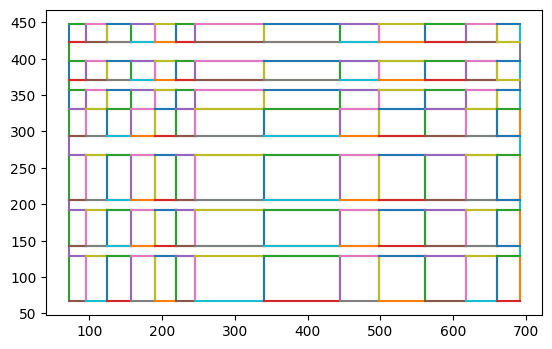

Label: {0: 'Cat. No.', 1: 'Locus', 2: 'Basket', 3: 'Weight (g)', 4: 'Diam. (mm)', 5: 'Axis', 6: 'Obverse', 7: 'Reverse', 8: 'Date (CE)', 9: 'Mint', 10: 'Reference', 11: 'Notes', 12: 'IAA No.'}
Mapping: {'Cat. No.': 'ID', 'Date (CE)': 'End_Year', 'Reference': 'Reference', 'Notes': 'Comment', 'grouping_label': 'Name'}
Label: {0: 'Cat. No.', 1: 'Locus', 2: 'Basket', 3: 'Weight (g)', 4: 'Diam. (mm)', 5: 'Axis', 6: 'Obverse', 7: 'Reverse', 8: 'Date (CE)', 9: 'Mint', 10: 'Reference', 11: 'Notes', 12: 'IAA No.'}
Mapping: {'Cat. No.': 'ID', 'Date (CE)': 'End_Year', 'Reference': 'Reference', 'Notes': 'Comment', 'grouping_label': 'Name'}
Label: {0: 'Cat. No.', 1: 'Locus', 2: 'Basket', 3: 'Weight (g)', 4: 'Diam. (mm)', 5: 'Axis', 6: 'Obverse', 7: 'Reverse', 8: 'Date (CE)', 9: 'Mint', 10: 'Reference', 11: 'Notes', 12: 'IAA No.'}
Mapping: {'Cat. No.': 'ID', 'Date (CE)': 'End_Year', 'Reference': 'Reference', 'Notes': 'Comment', 'grouping_label': 'Name'}
Label: {0: 'Cat. No.', 1: 'Locus', 2: 'Basket'

In [1150]:
tool = tk.Tk()
tool.title("COINS Tool")

upload_button = tk.Button(tool, text="Upload PDF", name='upload_button', command=lambda: upload_file(capture_button, tool))
capture_button = tk.Button(tool, text="Capture table", name="capture_button", command=lambda: on_capture_button_click(tool, mapping))

tk.Grid.columnconfigure(tool, 0, weight=1)
tk.Grid.columnconfigure(tool, 1, weight=1)
tk.Grid.rowconfigure(tool, 0, weight=1)

upload_button.grid(row=0, column=0, sticky="NSEW", columnspan=2)

tool.mainloop()

# Time: 4-

End